In [ ]:
pip install seaborn matplotlib

In [ ]:
import keras
import pandas as pd
import numpy as np
import itertools
import seaborn as sns
from sklearn import svm
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from keras.models import Sequential
from tensorflow.keras import models, layers
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from keras. layers import Activation, Dropout, Flatten, Dense
from sklearn.model_selection import train_test_split, cross_val_score
from keras.layers import Conv1D, MaxPooling2D, MaxPooling1D, BatchNormalization
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import warnings
warnings.filterwarnings('ignore')
def ignore_warn(*args, **kwargs):
  pass
  warnings.warn=ignore_warn

In [ ]:
BATCH_SIZE = 32
IMAGE_SIZE = 300
CHANNELS=3
EPOCHS=98

In [ ]:
!nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/Final_Dataset(RLDD)",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 1849 files belonging to 6 classes.


In [ ]:
class_names = dataset.class_names
class_names

['Bacterial_leaf_blight',
 'Brown_spot',
 'Healthy_leaf',
 'Leaf_Blast',
 'Other',
 'Tungro']

In [ ]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 300, 300, 3)
[5 5 0 5 5 1 3 0 1 3 1 2 3 1 1 4 2 4 2 0 0 0 4 2 3 1 2 5 5 2 5 2]


In [ ]:
len(dataset)

58

In [ ]:
new_image_size = (256, 256)
resized_dataset = dataset.map(lambda x, y: (tf.image.resize(x, new_image_size), y))
for image_batch, labels_batch in resized_dataset.take(1):
    print(image_batch.shape)

(32, 256, 256, 3)


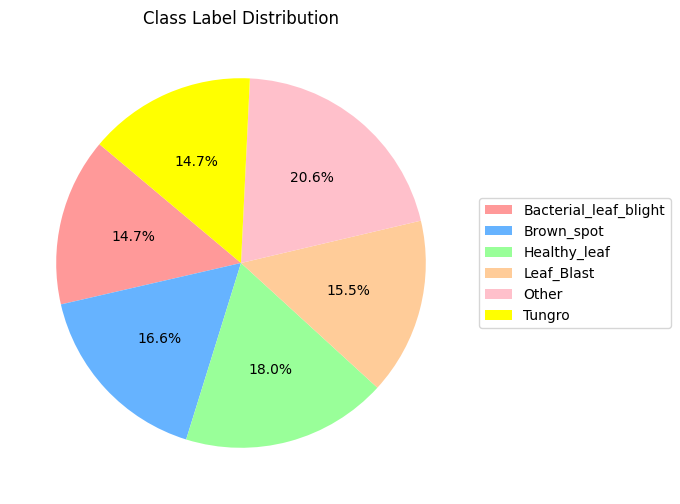

In [ ]:
import random
# Assuming you have a list of colors corresponding to each class
#class_colors = [f'#{random.randint(0, 0xFFFFFF):06x}' for _ in class_names]'
class_colors = ['#ff9999','#66b3ff','#99ff99','#ffcc99',"pink","yellow"]
class_counts = [0] * len(class_names)
for images_batch, labels_batch in resized_dataset:# resized_dataset
    for label in labels_batch:
        class_counts[label] += 1

plt.figure(figsize=(6, 6))
patches, texts, autotexts = plt.pie(class_counts,
                                   autopct='%1.1f%%', startangle=140, colors=class_colors)

plt.legend(patches, class_names, loc='center left', bbox_to_anchor=(1, 0.5))

plt.title("Class Label Distribution")
plt.show()

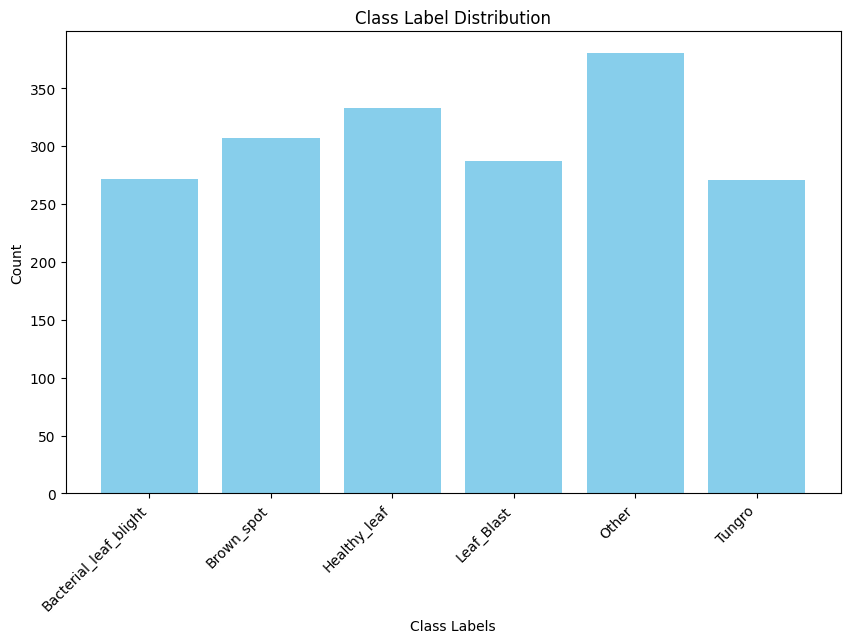

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Create a list to store the count of each class label
class_counts = [0] * len(class_names)
for images_batch, labels_batch in resized_dataset:
    for label in labels_batch:
        class_counts[label] += 1

# Plotting the bar chart
plt.figure(figsize=(10, 6))
plt.bar(class_names, class_counts, color='skyblue')
plt.title("Class Label Distribution")
plt.xlabel("Class Labels")
plt.ylabel("Count")
plt.xticks(rotation=45, ha="right")
plt.show()

**Visualize some of the images from our datasetmodel**

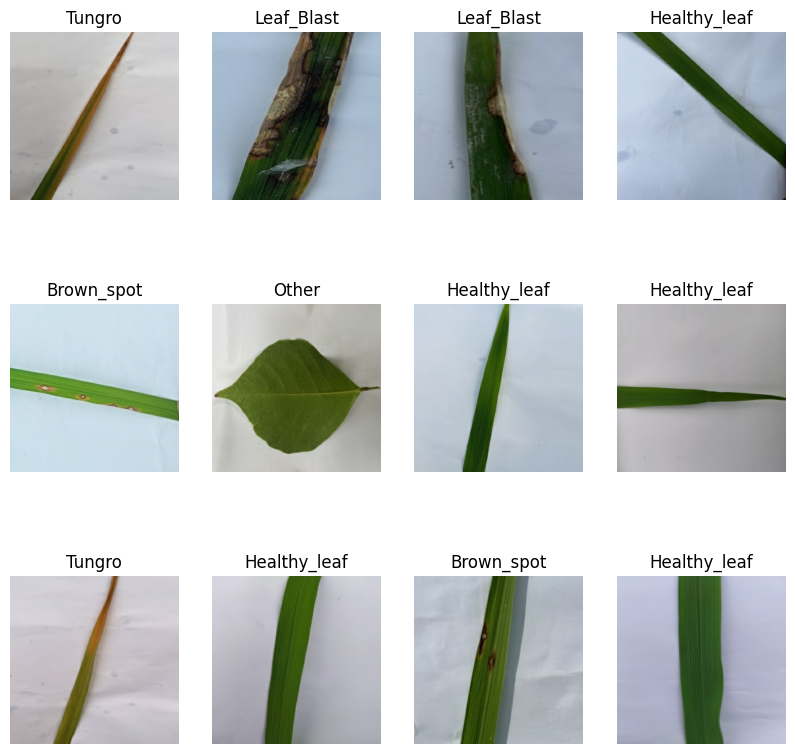

In [ ]:
plt.figure(figsize=(10, 10))
for image_batch, label_batch in resized_dataset.take(1):
  for i in range(12):
    ax = plt.subplot(3,4,i+1)
    plt.imshow(image_batch[i].numpy().astype("uint8"))
    plt.title(class_names[label_batch[i]])
    plt.axis("off")
  #print(image_batch[0].shape)

**Apply Histogram equalization**

Input image shape: (256, 256, 3)
Input image type: float32
Converted image shape: (256, 256)
Converted image type: float32


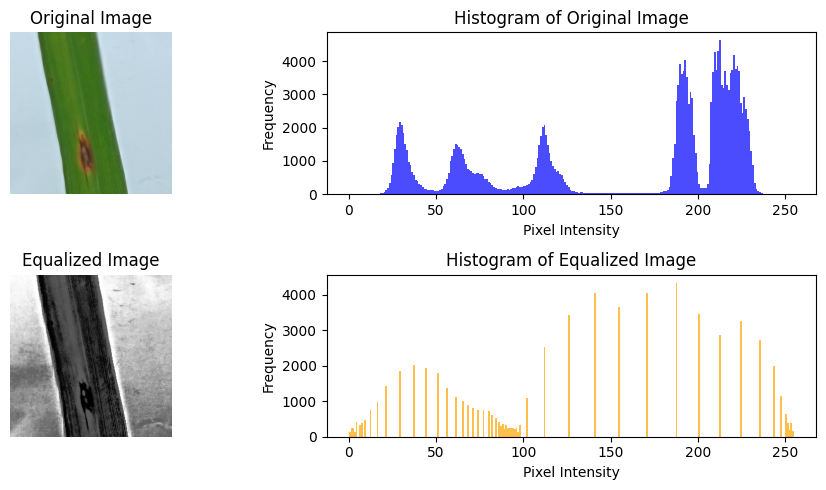

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
import numpy as np

# Function to apply histogram equalization to an image using OpenCV
def apply_histogram_equalization(image):
    try:
        print("Input image shape:", image.shape)
        print("Input image type:", image.dtype)

        # Convert image to grayscale if it's in RGB format
        if image.shape[-1] == 3:
            image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

        print("Converted image shape:", image.shape)
        print("Converted image type:", image.dtype)

        # Ensure the image is in the correct type (uint8) for OpenCV equalizeHist
        image = image.astype('uint8')

        equalized_image = cv2.equalizeHist(image)

        return equalized_image
    except Exception as e:
        print(f"Error processing image: {e}")
        return None

# Function to visualize original and equalized images along with their histograms
def visualize_histogram_equalization(original_image, equalized_image):
    # Plot original image
    plt.figure(figsize=(10, 5))
    plt.subplot(2, 2, 1)
    plt.imshow(original_image, cmap='gray')
    plt.title('Original Image')
    plt.axis('off')

    # Plot histogram of original image
    plt.subplot(2, 2, 2)
    plt.hist(original_image.ravel(), bins=256, range=[0, 255], color='blue', alpha=0.7)
    plt.title('Histogram of Original Image')
    plt.xlabel('Pixel Intensity')
    plt.ylabel('Frequency')

    # Plot equalized image
    plt.subplot(2, 2, 3)
    plt.imshow(equalized_image, cmap='gray')
    plt.title('Equalized Image')
    plt.axis('off')

    # Plot histogram of equalized image
    plt.subplot(2, 2, 4)
    plt.hist(equalized_image.ravel(), bins=256, range=[0, 255], color='orange', alpha=0.7)
    plt.title('Histogram of Equalized Image')
    plt.xlabel('Pixel Intensity')
    plt.ylabel('Frequency')

    plt.tight_layout()
    plt.show()

# Apply histogram equalization to an example image
for image, _ in resized_dataset.take(1):
    equalized_image = apply_histogram_equalization(image[0].numpy())
    if equalized_image is not None:
        # Clip pixel values to valid range [0, 255]
        original_image = np.clip(image[0].numpy(), 0, 255).astype(np.uint8)
        equalized_image = np.clip(equalized_image, 0, 255).astype(np.uint8)
        visualize_histogram_equalization(original_image, equalized_image)



**Apply Gamma correction**

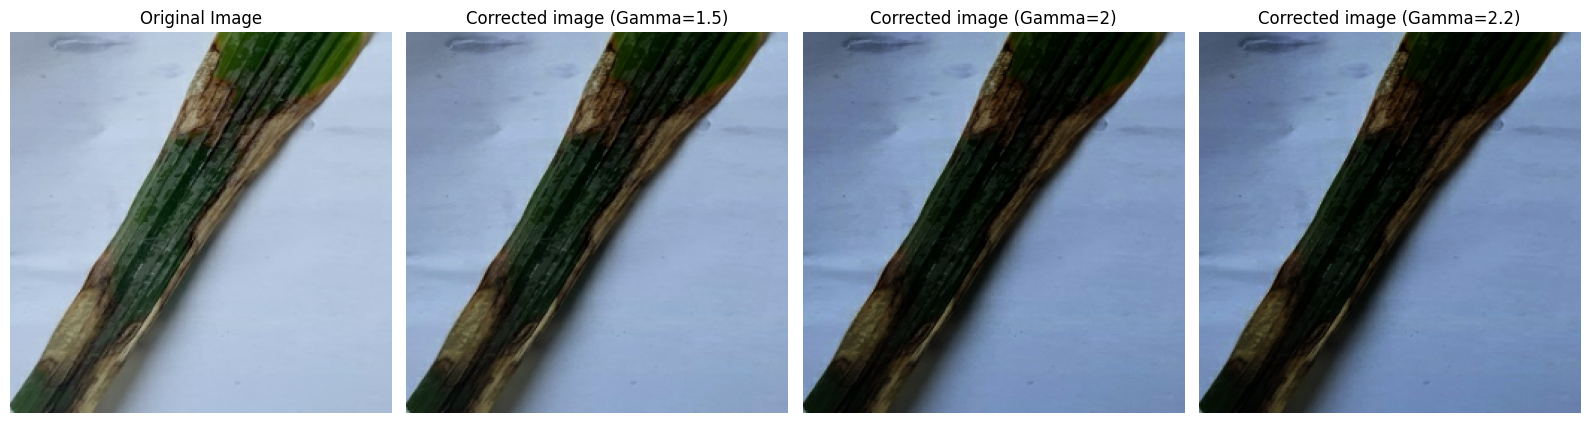

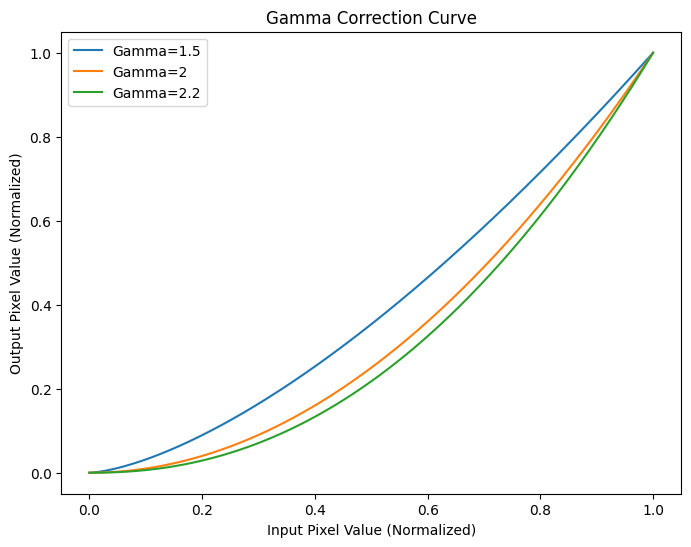

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
import numpy as np

def apply_gamma_correction(image, gamma):
    try:
        # Normalize pixel values to the range [0, 1]
        image_normalized = image / 255.0
        corrected_image = np.power(image_normalized, gamma)
        corrected_image = (corrected_image * 255).astype(np.uint8)
        return corrected_image
    except Exception as e:
        print(f"Error processing image: {e}")
        return None

# Function to visualize original and corrected images along with gamma correction curve
def visualize_gamma_correction(original_image, corrected_image_list, gamma_list):
    # Clip pixel values to the valid range [0, 255]
    original_image = np.clip(original_image, 0, 255).astype(np.uint8)
    corrected_image_list = [np.clip(image, 0, 255).astype(np.uint8) for image in corrected_image_list]

    # Plot original image and corrected images
    num_images = len(corrected_image_list) + 1
    plt.figure(figsize=(4 * num_images, 5))
    plt.subplot(1, num_images, 1)
    plt.imshow(original_image, cmap='gray')
    plt.title('Original Image')
    plt.axis('off')

    for i, corrected_image in enumerate(corrected_image_list):
        plt.subplot(1, num_images, i + 2)
        plt.imshow(corrected_image, cmap='gray')
        plt.title(f'Corrected image (Gamma={gamma_list[i]})')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

    # Plot gamma correction curve
    plt.figure(figsize=(8, 6))
    for gamma in gamma_list:
        plt.plot(np.arange(0, 256) / 255.0, (np.arange(0, 256) / 255.0) ** gamma, label=f'Gamma={gamma}')
    plt.title('Gamma Correction Curve')
    plt.xlabel('Input Pixel Value (Normalized)')
    plt.ylabel('Output Pixel Value (Normalized)')
    plt.legend()
    plt.show()

# Apply gamma correction with multiple gamma values to an example image
gamma_list = [1.5, 2, 2.2]  # Set gamma values
corrected_image_list = []
for image, _ in resized_dataset.take(1):
    original_image = image[0].numpy()
    for gamma in gamma_list:
        corrected_image = apply_gamma_correction(original_image, gamma)
        if corrected_image is not None:
            corrected_image_list.append(corrected_image)

if corrected_image_list:
    visualize_gamma_correction(original_image, corrected_image_list, gamma_list)


Edge Detection

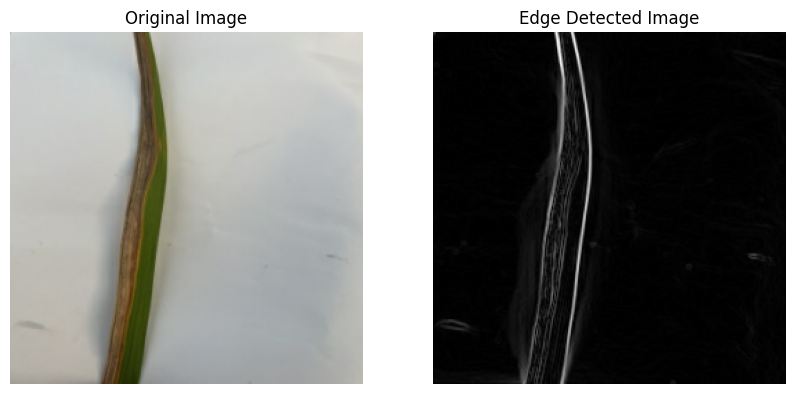

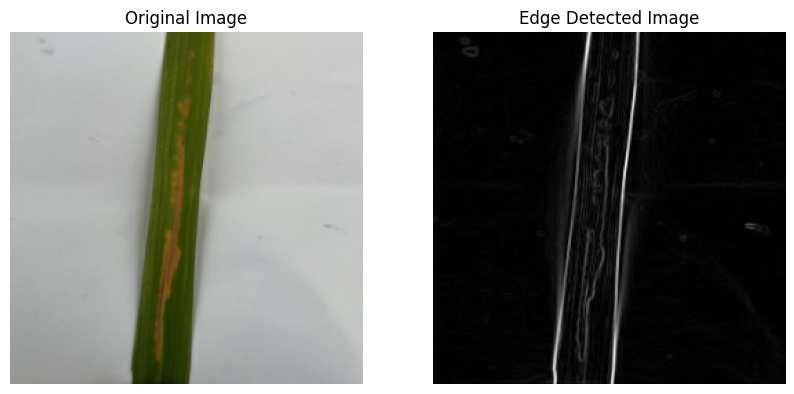

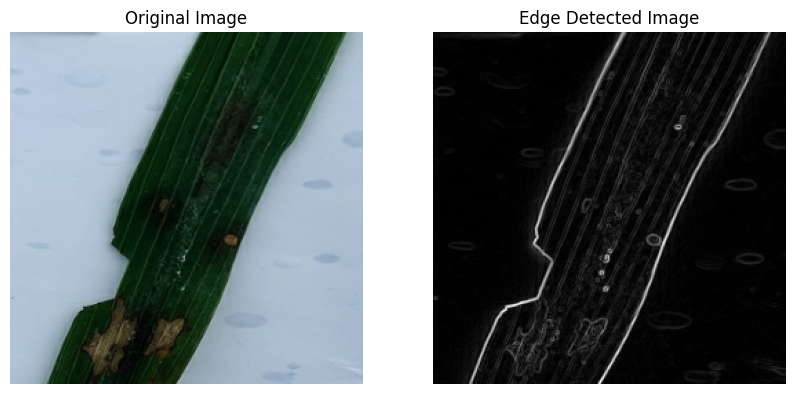

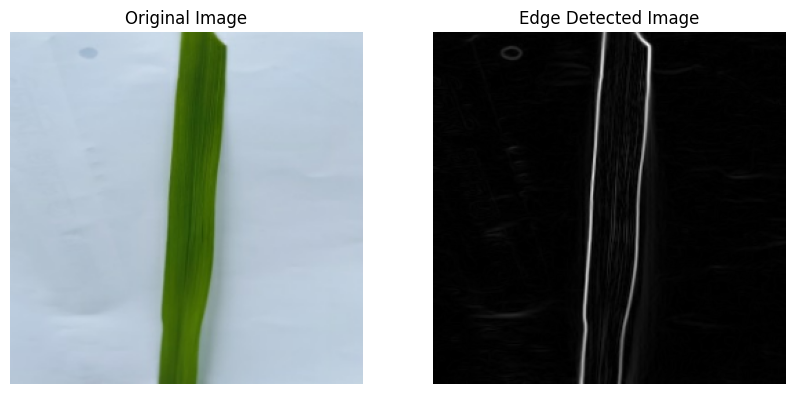

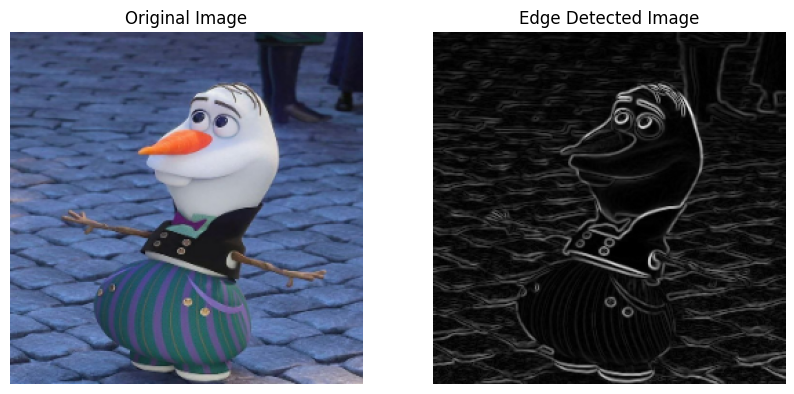

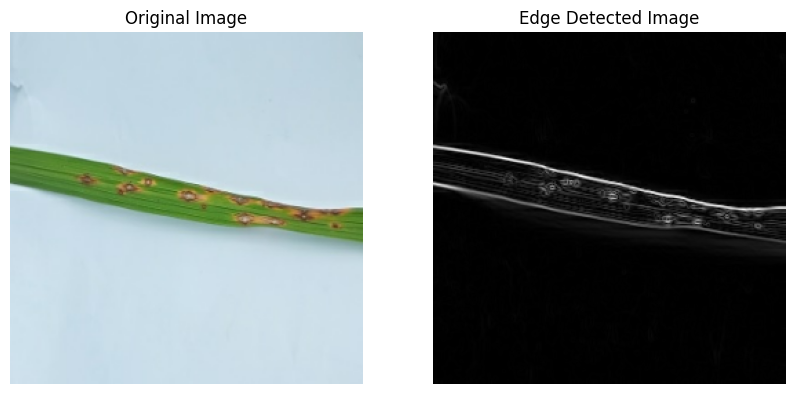

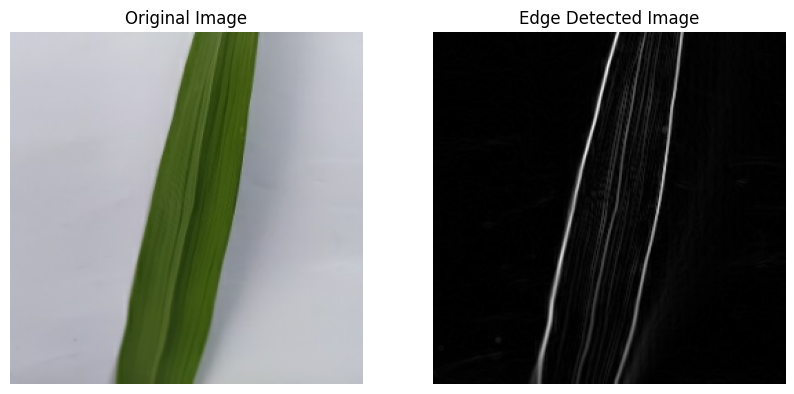

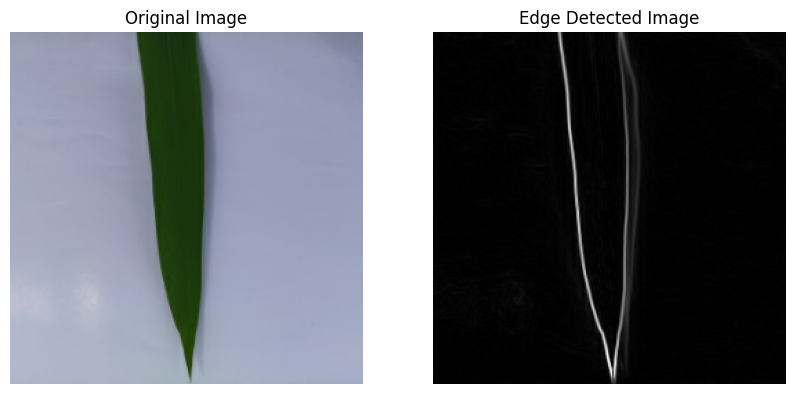

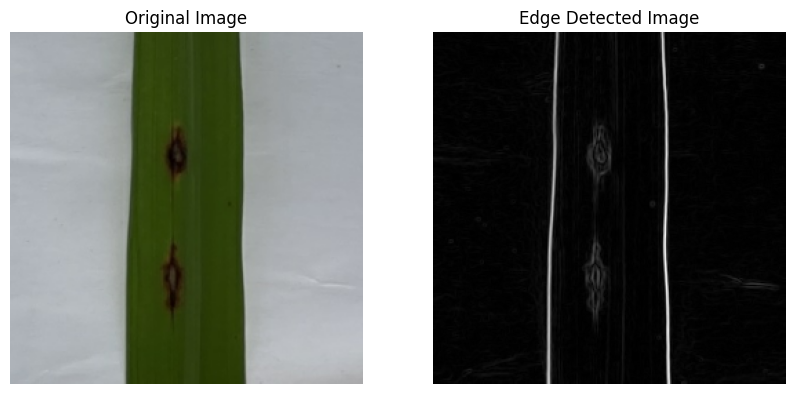

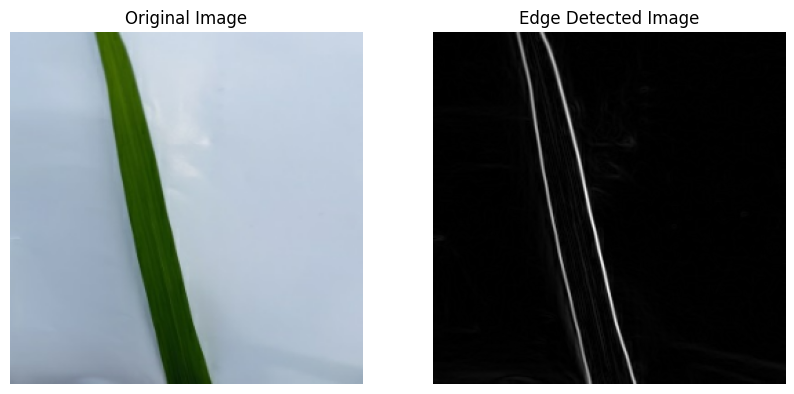

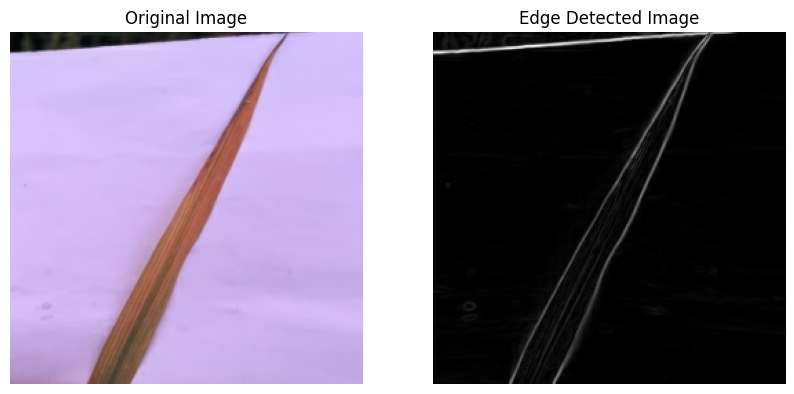

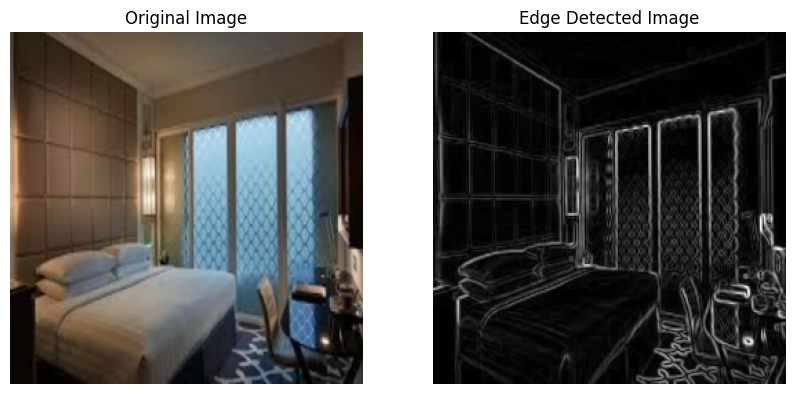

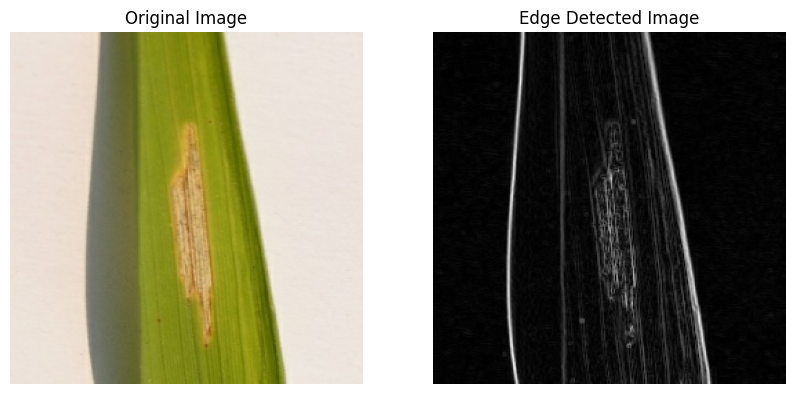

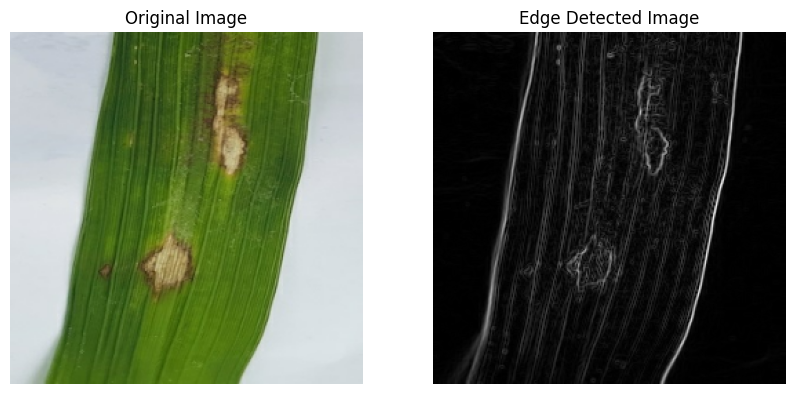

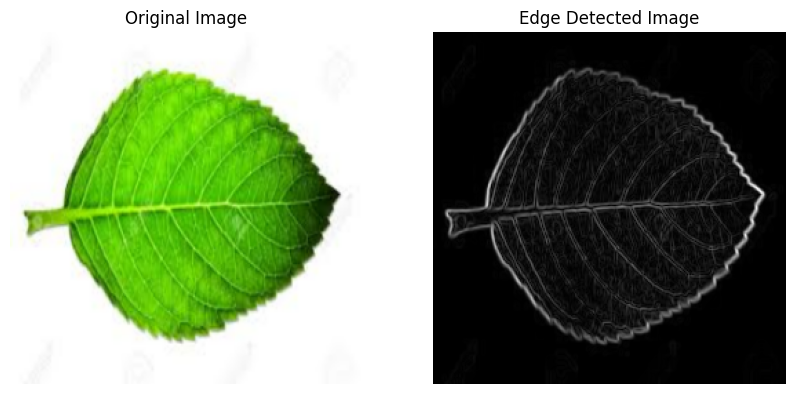

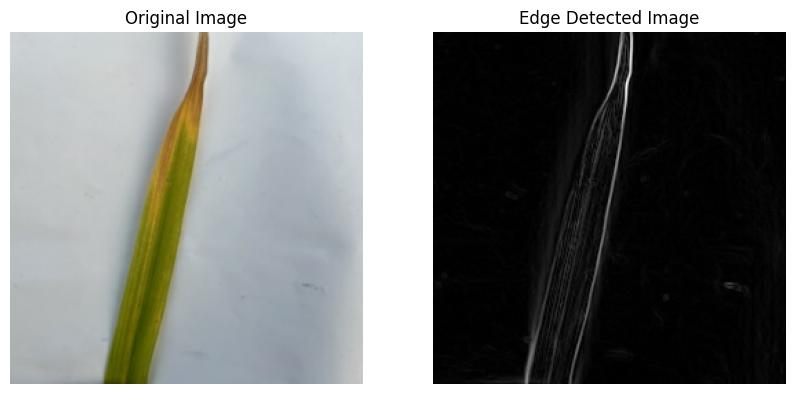

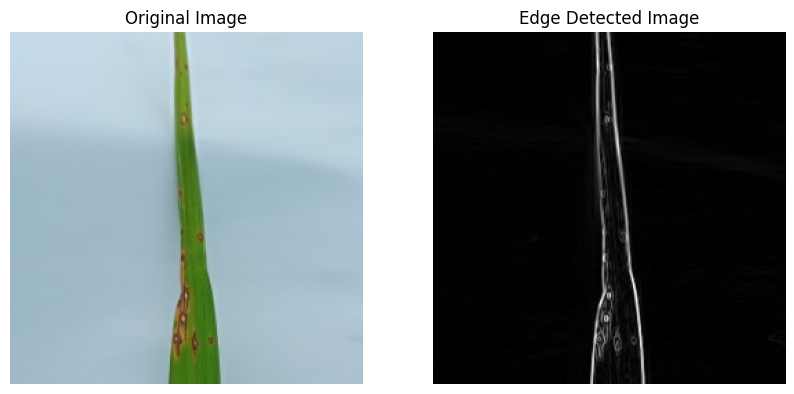

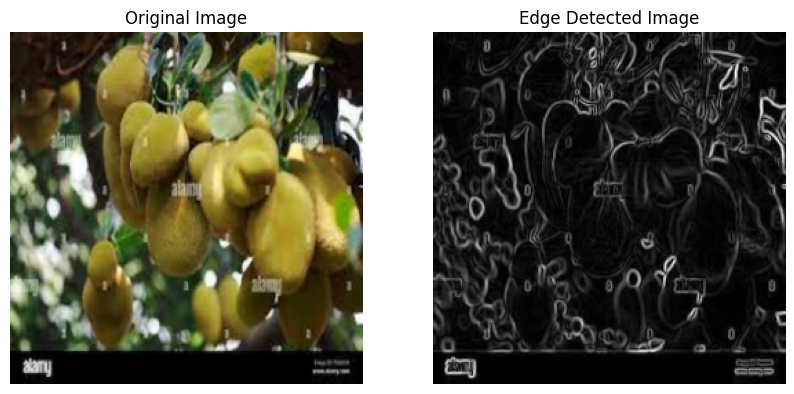

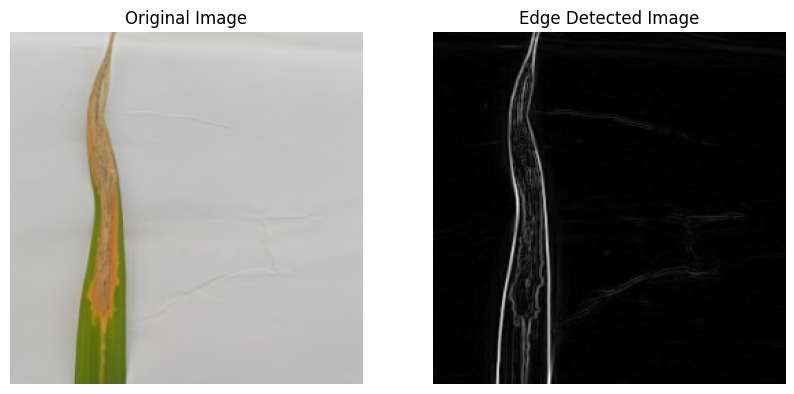

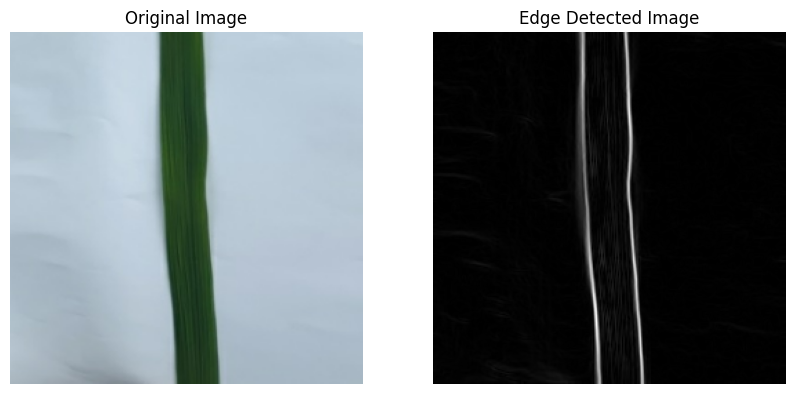

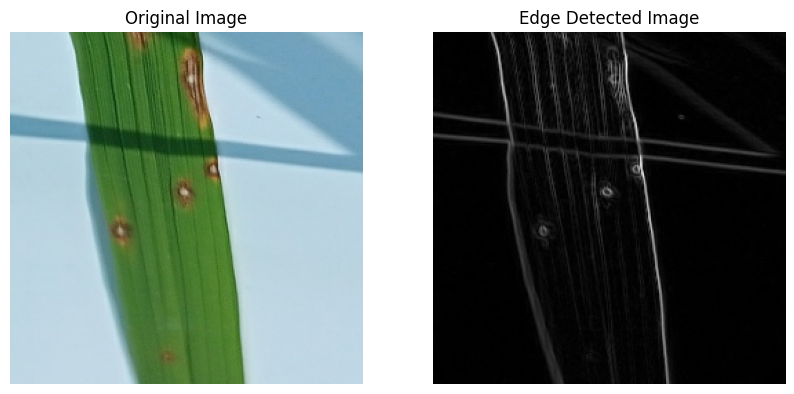

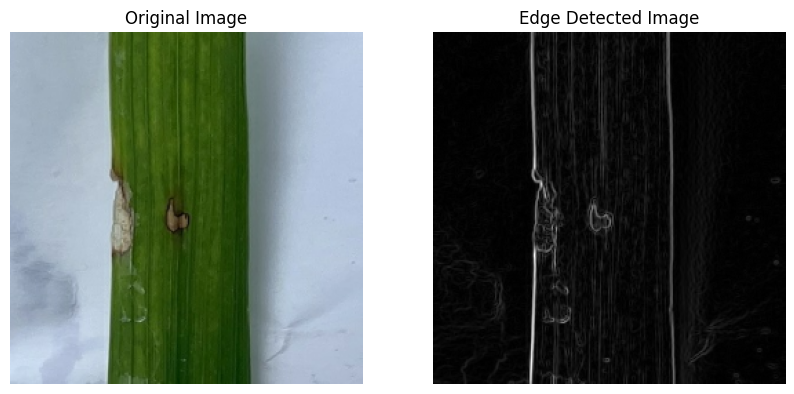

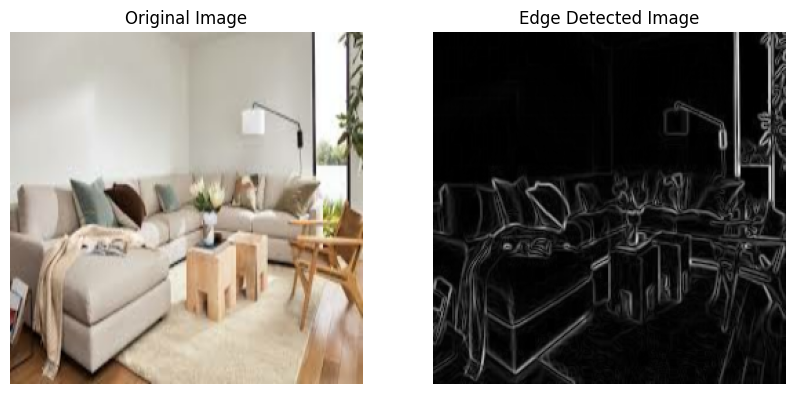

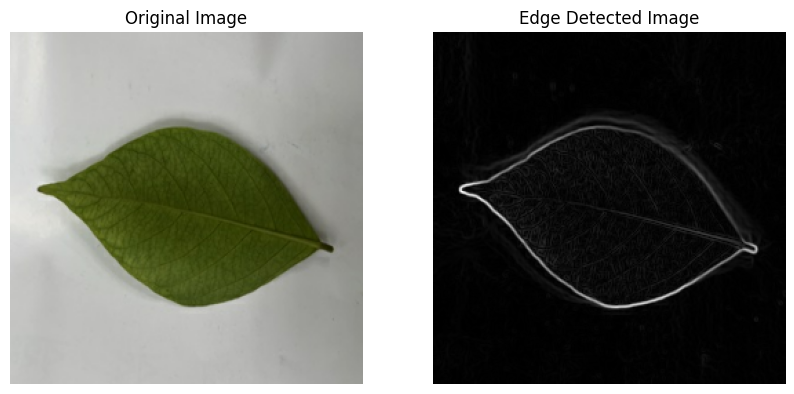

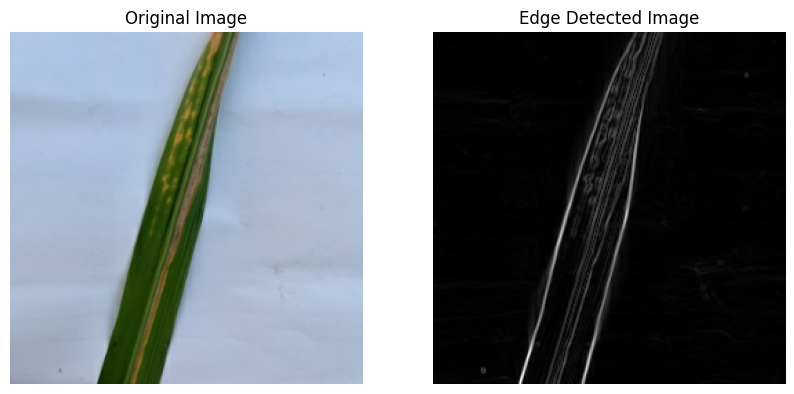

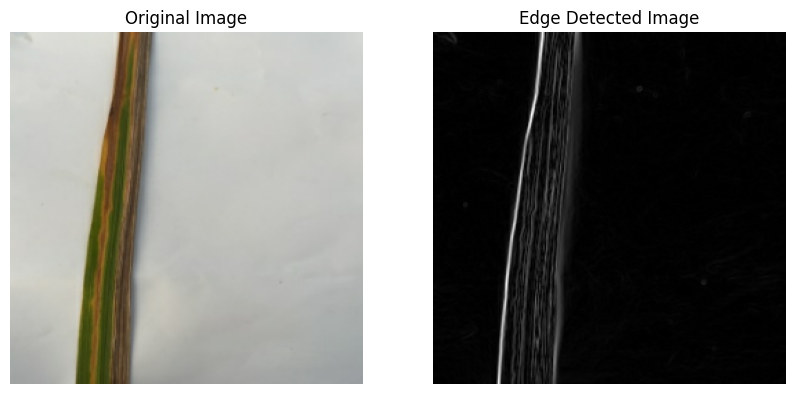

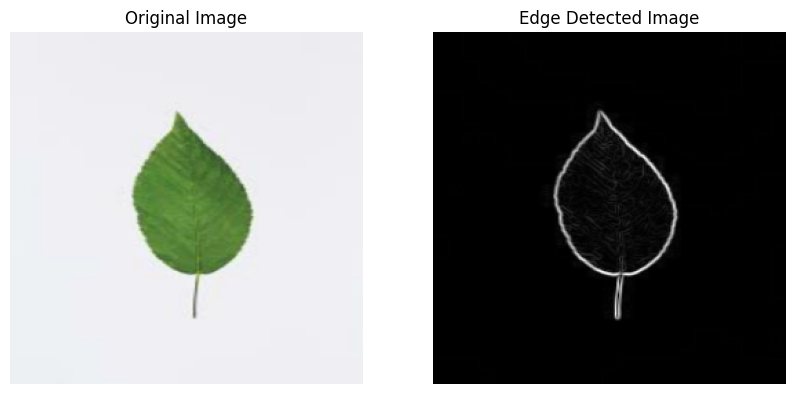

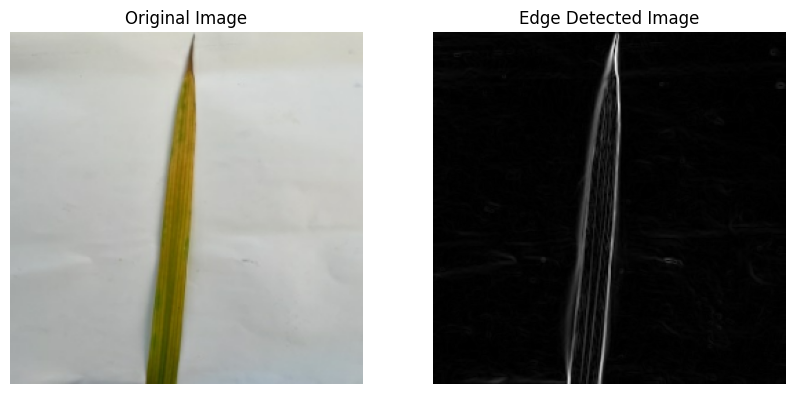

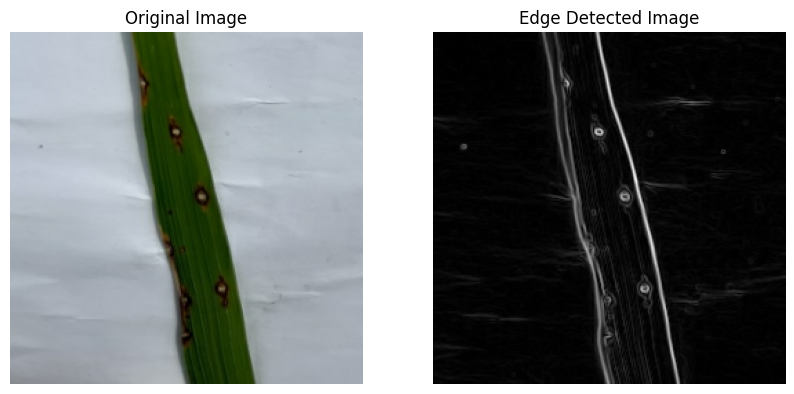

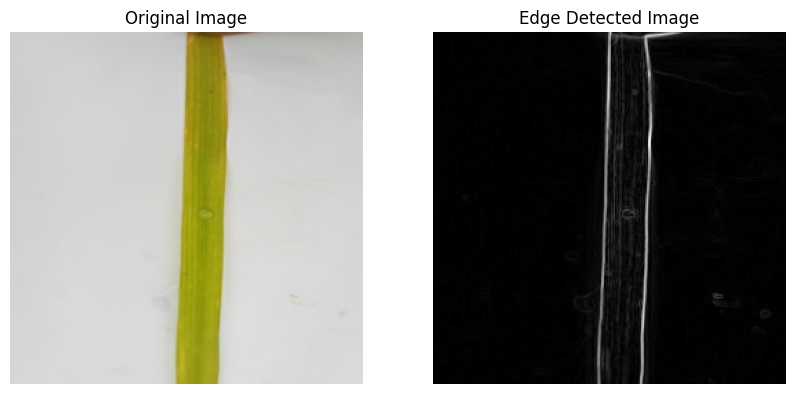

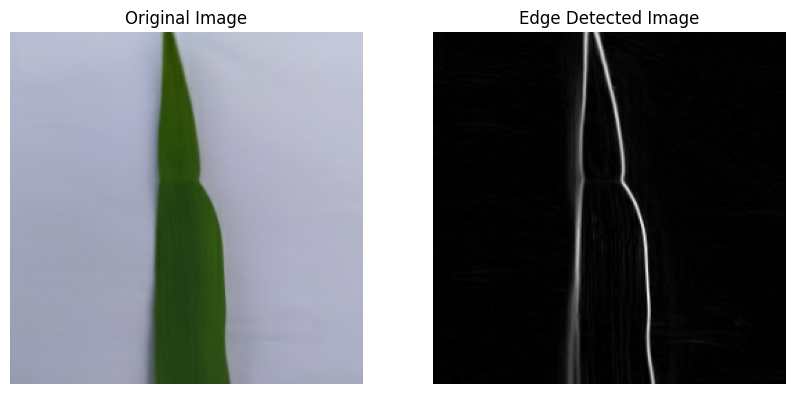

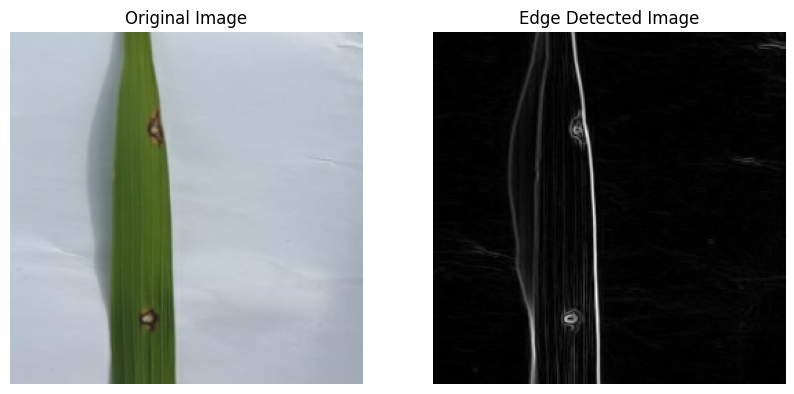

In [ ]:
!pip install seaborn matplotlib scikit-image

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from skimage import filters

# Define the function to apply Sobel edge detection
def sobel_edge_detection(image):
    # Convert image to grayscale
    grayscale_image = tf.image.rgb_to_grayscale(image)
    grayscale_image = tf.squeeze(grayscale_image, axis=-1)

    # Apply Sobel operator for edge detection
    edge_detected_image = filters.sobel(grayscale_image.numpy())

    return edge_detected_image

# Applying edge detection to the resized_dataset
for image_batch, labels_batch in resized_dataset.take(1):
    for image in image_batch:
        edge_detected_image = sobel_edge_detection(image)
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        plt.imshow(image.numpy().astype("uint8"))
        plt.title("Original Image")
        plt.axis("off")

        plt.subplot(1, 2, 2)
        plt.imshow(edge_detected_image, cmap='gray')
        plt.title("Edge Detected Image")
        plt.axis("off")

        plt.show()


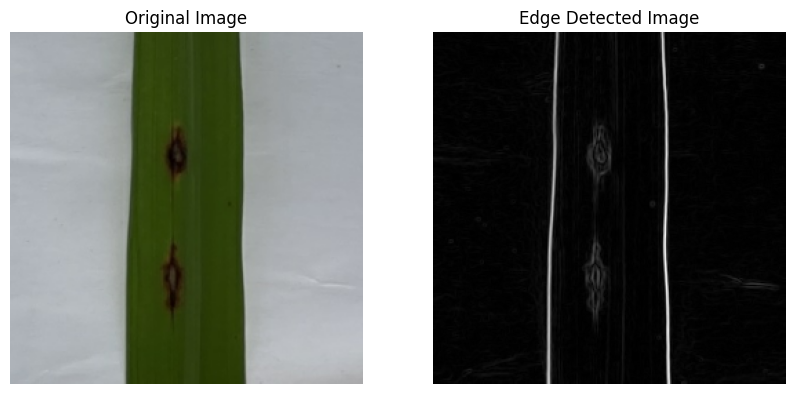

In [ ]:
import random

# Function to apply Sobel edge detection to a randomly selected image
def apply_edge_detection(dataset):
    for image_batch, labels_batch in dataset.take(1):
        # Select a random image from the batch
        random_index = random.randint(0, len(image_batch) - 1)
        image = image_batch[random_index]

        # Apply Sobel edge detection
        edge_detected_image = sobel_edge_detection(image)

        # Display the original and edge-detected images
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        plt.imshow(image.numpy().astype("uint8"))
        plt.title("Original Image")
        plt.axis("off")

        plt.subplot(1, 2, 2)
        plt.imshow(edge_detected_image, cmap='gray')
        plt.title("Edge Detected Image")
        plt.axis("off")

        plt.show()

# Apply edge detection to the resized_dataset
apply_edge_detection(resized_dataset)
